## Forecasting C02 concentrations at Mauna Loa 

Here we will use a variety of TS techniques to forecast some C02 data, and compare the results to see what works best. We'll keep things simple and
only use one variable, the timeseries values themselves, but in future we could also inttroduce exogenous variables

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from scipy.signal import welch
import numpy as np

In [1]:
#models from statsmodels
import statsmodels.tsa.holtwinters as ts
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [3]:
#Useful function to conduct the ADF test and return output

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

Exploring the dataset

In [4]:
df = pd.read_csv('data/co2_mm_mlo.csv',parse_dates=True)

In [5]:
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


In [6]:
df['date'] = pd.to_datetime({'year':df['year'],'month':df['month'],'day':1})

In [7]:
df.set_index(df['date'],inplace=True)

In [8]:
df.head()

,year,month,decimal_date,average,interpolated,date
date,,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71,1958-03-01
1958-04-01,1958,4,1958.292,317.45,317.45,1958-04-01
1958-05-01,1958,5,1958.375,317.50,317.50,1958-05-01
1958-06-01,1958,6,1958.458,NaN,317.10,1958-06-01
1958-07-01,1958,7,1958.542,315.86,315.86,1958-07-01


In [13]:
df.index.freq = 'MS'

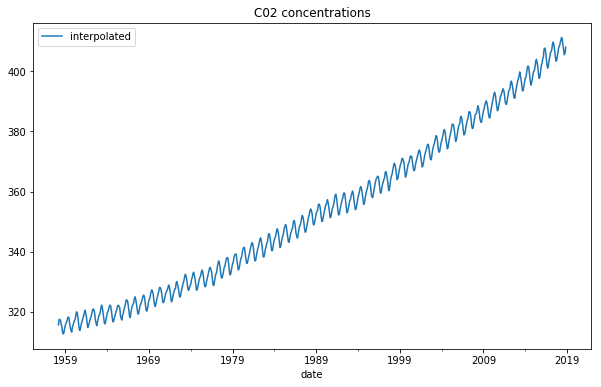

In [12]:
#Here is the timseries we want to forecast. Ideally it would be good to predict 5 years into the future, so lets keep that in mind
df['interpolated'].plot(figsize=(10,6),legend=True,title='C02 concentrations');

In [15]:
#ETS decomposition
decomp = seasonal_decompose(df['interpolated'])

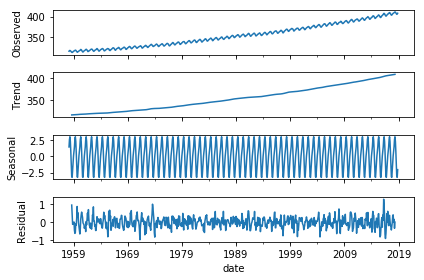

In [19]:
#Clearly we have a trend and seasonal component here. 
decomp.plot();

In [41]:
#To understand the seasonality, let plot a peridogram
freq = 1 #note monthly data here 
f, Pxx_den = welch(df['interpolated'], freq,nperseg=512)

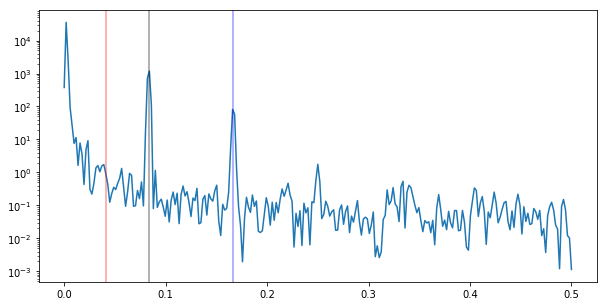

In [42]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.semilogy(f,Pxx_den)
ax.axvline(1/12,color='k',alpha=0.4) #peak at yearly cycle 
ax.axvline(1/24,color='r',alpha=0.4) #not a peak at two year cycle
ax.axvline(1/6,color='b',alpha=0.4) #lesser peak at 6 month cycle

#The highest point occurs at very low frequency, and may be related to the trend itself. Its clear that the yearly cycle is dominant here

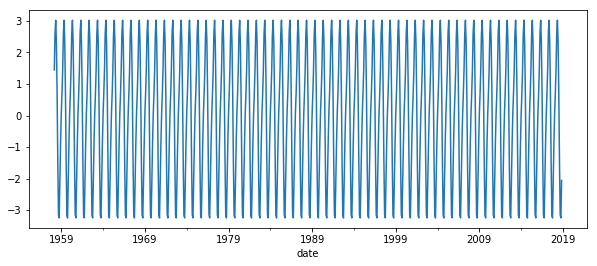

In [43]:
decomp.seasonal.plot(figsize=(10,4))

In [44]:
f, Pxx_den = welch(decomp.seasonal, freq,nperseg=512)

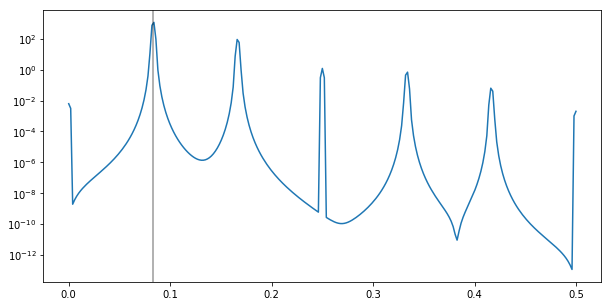

In [45]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.semilogy(f,Pxx_den)
ax.axvline(1/12,color='k',alpha=0.4) #peak at yearly cycle 

### Fitting some models 

We'll do a test-train split and then try fitting a range of models to see what works best. This timeseries is quite simple, so we should hopefully get some decent results. The models we'll try are as follows:

- Holt winters (exponential smoothing) 
- ARIMA
- SARIMA 
- RNN
- Facebook's Prophet library (curve fitting) 

The timeseries has strong seasonalty, so we would expect the ARIMA to perform badly. The rest should do well though

### Test-train split

In [48]:
test_idx = 5*12
train = df['interpolated'][:-test_idx]
test = df['interpolated'][-test_idx:]

In [55]:
def report_errors(predicted,test):
    
    rmse_error = mean_squared_error(test,predicted)
    percent_rmse = rmse_error/np.mean(test)
    
    print('RMSE: %.3f' %rmse_error)
    print('percent RMSE: %.3f' %percent_rmse)
    
    predicted.plot(legend=True)
    test.plot(legend=True)
    
    return rmse_error,percent_rmse

### Holt-Winters

In [65]:
%%time
HW_model = ts.ExponentialSmoothing(train,\
                                      trend='add',seasonal='mul',\
                                      seasonal_periods=12).fit()

CPU times: user 10.9 s, sys: 15 ms, total: 11 s
Wall time: 11 s


In [66]:
HW_forecast = HW_model.forecast(test_idx).rename('HW predictions')

RMSE: 1.620
percent RMSE: 0.004


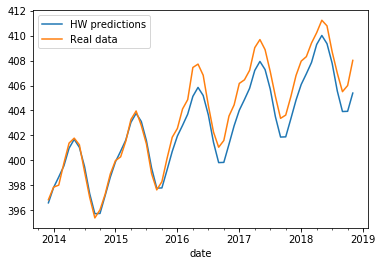

In [68]:
rmse_HW, p_rmse_HW = report_errors(HW_forecast,test.rename('Real data'))

Notes: Changing the trend to 'additive' from 'mul' signifiantly improves the performance, even though the overall shape of the timeseries looks like it should be multiplicative. A multiplicative seasonal component is preferable to an additive one.

### ARIMA

In [70]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [72]:
%%time
auto_arima(train,seasonal=False).summary()

CPU times: user 1.7 s, sys: 14.4 ms, total: 1.72 s
Wall time: 905 ms


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  668
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -713.547
Method:                       css-mle   S.D. of innovations              0.703
Date:                Mon, 06 May 2019   AIC                           1441.093
Time:                        17:10:59   BIC                           1472.623
Sample:                             1   HQIC                          1453.308
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1240      0.039      3.147      0.002       0.047       0.201
ar.L1.D.y      0.8713      0.038     22.677      0.000       0.796       0.947
ar.L2.D.y     -0.2047      0.051     -4.002      0.000      -0.305      -0.104
ar.L3.D.y     -0.2779      0.051     -5.484      0.000      -0.377      -0.179
ar.L4.D.y      0.0460      0.051      0.898      0.370      -0.054       0.146
ar.L5.D.y     -0.1264      0.039     -3.281      0.001      -0.202      -0.051
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9076           -0.6606j            1.1226           -0.1001
AR.2            0.9076           +0.6606j            1.1226            0.1001
AR.3           -1.6269           -0.0000j            1.6269           -0.5000
AR.4            0.0877           -1.9625j            1.9645           -0.2429
AR.5            0.0877           +1.9625j            1.9645            0.2429
-----------------------------------------------------------------------------
"""

In [77]:
%%time
model = ARIMA(train,order=(5,1,0))
ARIMA_model = model.fit()

CPU times: user 455 ms, sys: 3.69 ms, total: 458 ms
Wall time: 243 ms


In [79]:
ARIMA_forecast = ARIMA_model.predict(start=len(train),end=len(train)+len(test)-1,typ='levels').rename('ARIMA predictions')

RMSE: 14.016
percent RMSE: 0.035


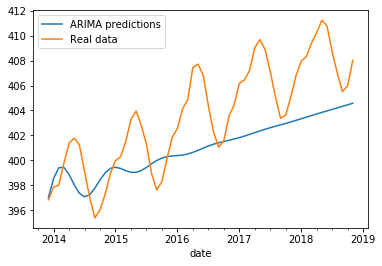

In [80]:
rmse_ARIMA, p_rmse_ARIMA = report_errors(ARIMA_forecast,test.rename('Real data'))

Since the ARIMA lacks a seasonal component, it performs poorly here

### SARIMA

In [83]:
%%time
auto_arima(train,seasonal=True,m=12).summary()

CPU times: user 1min 3s, sys: 509 ms, total: 1min 3s
Wall time: 57.6 s


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  669
Model:             SARIMAX(0, 1, 2)x(1, 0, 1, 12)   Log Likelihood                -169.805
Date:                            Mon, 06 May 2019   AIC                            351.610
Time:                                    17:17:42   BIC                            378.635
Sample:                                         0   HQIC                           362.079
                                            - 669                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.001      1.211      0.226      -0.001       0.002
ma.L1         -0.3674      0.038     -9.786      0.000      -0.441      -0.294
ma.L2         -0.0649      0.040     -1.621      0.105      -0.143       0.014
ar.S.L12       0.9995      0.000   3069.974      0.000       0.999       1.000
ma.S.L12      -0.8644      0.023    -37.409      0.000      -0.910      -0.819
sigma2         0.0908      0.005     18.515      0.000       0.081       0.100
===================================================================================
Ljung-Box (Q):                       52.60   Jarque-Bera (JB):                 1.65
Prob(Q):                              0.09   Prob(JB):                         0.44
Heteroskedasticity (H):               1.02   Skew:                            -0.09
Prob(H) (two-sided):                  0.88   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
%%time
model = SARIMAX(train,order=(0,1,2),seasonal_order=(1,0,1,12))
SARIMA_model = model.fit()

CPU times: user 1.39 s, sys: 14.5 ms, total: 1.41 s
Wall time: 1.25 s


In [85]:
SARIMA_forecast = SARIMA_model.predict(start=len(train),end=len(train)+len(test)-1,typ='levels').rename('SARIMA predictions')

RMSE: 2.151
percent RMSE: 0.005


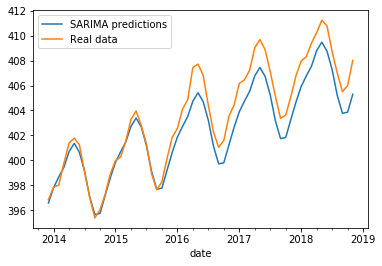

In [86]:
rmse_SARIMA, p_rmse_SARIMA = report_errors(SARIMA_forecast,test.rename('Real data'))

This model performs very similarly to the Holt-Winters method, which suggests that a curve-fitting exercise is probably appropraite here

### RNN 

This will take longer and has more parameters that we can tune to improve it. Its not obvious how we might choose n_input, the number of ts steps to learn from, for example, or the number of neurons in the network. It seems unlikely that any improvement made will justify the much longer time this takes to run. 

In [93]:
import keras 
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense 
from keras.layers import LSTM

In [90]:
scaler = MinMaxScaler()
scaler.fit(train.values.reshape(-1, 1))
scaled_train = scaler.transform(train.values.reshape(-1, 1))
scaled_test = scaler.transform(test.values.reshape(-1, 1))

In [131]:
n_input = 12 #the larger this value, the more information will get included in the training. We want to include at least 5 years worth of 
#data in order to predict the future, and can extend this
n_features = 1 #We are only using the ts values to do the prediction here

In [132]:
#source of data and source of test are the same vector
train_generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [133]:
#Set up the RNN model, with just one layer of neurons
RNNmodel = Sequential()

#what number of neurons? a good starting point is about 100
#n_input is how many steps before the predicted value we see, n_features in the number 
#of features we're fitting
RNNmodel.add(LSTM(50,activation='relu',input_shape=[n_input,n_features])) 
RNNmodel.add(Dense(1))
RNNmodel.compile(optimizer='adam',loss='mse')

In [134]:
RNNmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [135]:
%%time
RNNmodel.fit_generator(train_generator,epochs=10)

Epoch 1/10
657/657 [==============================] - 9s 14ms/step - loss: 0.0102
Epoch 2/10
657/657 [==============================] - 8s 12ms/step - loss: 9.1420e-04
Epoch 3/10
657/657 [==============================] - 8s 12ms/step - loss: 0.0010
Epoch 4/10
657/657 [==============================] - 9s 13ms/step - loss: 9.0787e-04
Epoch 5/10
657/657 [==============================] - 9s 13ms/step - loss: 8.4894e-04
Epoch 6/10
657/657 [==============================] - 9s 13ms/step - loss: 7.5238e-04
Epoch 7/10
657/657 [==============================] - 9s 13ms/step - loss: 7.4369e-04
Epoch 8/10
657/657 [==============================] - 9s 14ms/step - loss: 6.6197e-04
Epoch 9/10
657/657 [==============================] - 9s 13ms/step - loss: 5.0150e-04
Epoch 10/10
657/657 [==============================] - 9s 13ms/step - loss: 4.2540e-04
CPU times: user 2min 30s, sys: 42.5 s, total: 3min 13s
Wall time: 1min 27s


Text(0, 0.5, 'Loss')

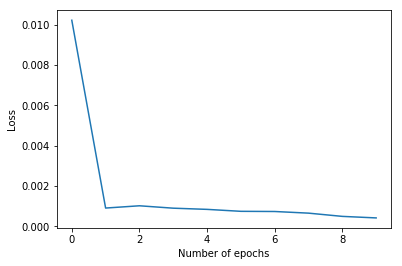

In [137]:
plt.plot(RNNmodel.history.history['loss']);
plt.xlabel('Number of epochs')
plt.ylabel('Loss')

In [138]:
#Forecast the test set now
test_predictions = []
#Got to make sure the dimensions are corrent
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1,n_input,n_features))

#How far in the future can be forecasted here? 
for i in range(len(test)):
    
    current_pred = RNNmodel.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    #update the current batch with the prediction that we've just made 
    #DROP the first value from the current batch and add the prediction to this point. Since we're marching 
    #though the data we need to add the values we've actually predicted. Thus the model sees nothing of the
    #test set
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [139]:
test_df = pd.DataFrame(test)
test_df['RNN_predictions'] = scaler.inverse_transform(test_predictions)

RMSE: 6.561
percent RMSE: 0.016


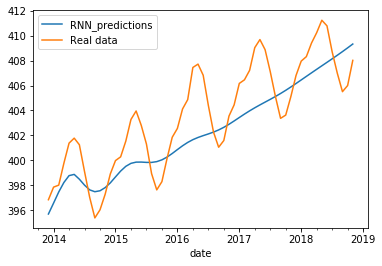

In [141]:
rmse_RNN, p_rmse_RNN = report_errors(test_df['RNN_predictions'],test.rename('Real data'))

Perhaps surprisingly, this does not seem to work very well at all. Its not clear why this is happening and this is one of the issues with ANNs

### Prophet 

In [142]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import add_changepoints_to_plot

The dataframe must be in a specific format here

In [143]:
ptrain = pd.DataFrame(train)

In [145]:
ptrain['ds'] = ptrain.index

In [148]:
ptrain.reset_index(drop=True,inplace=True)

In [150]:
ptrain.columns = ['y','ds']

In [165]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(ptrain)
future = m.make_future_dataframe(periods=test_idx,freq='MS')
fbP_forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


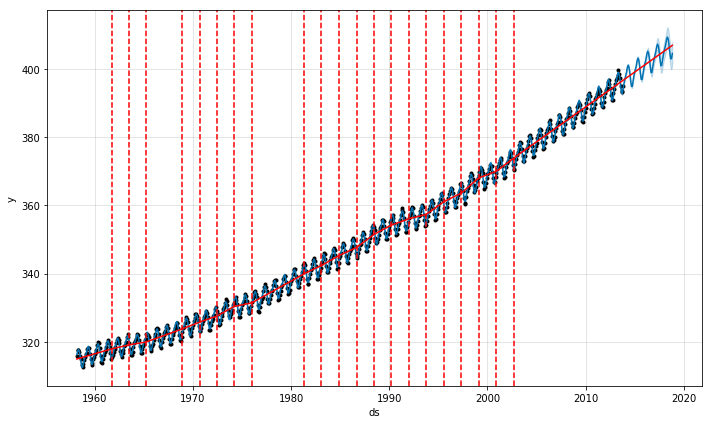

In [166]:
fig = m.plot(fbP_forecast)
a = add_changepoints_to_plot(fig.gca(),m,fbP_forecast)

In [167]:
fbP_predictions = fbP_forecast[['ds','yhat']].iloc[-test_idx:].set_index('ds')['yhat'].rename('Prophet predictions')

RMSE: 3.294
percent RMSE: 0.008


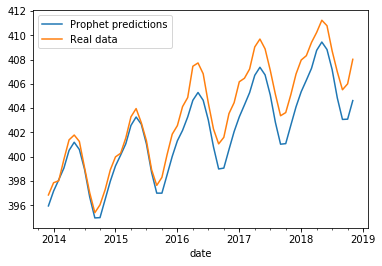

In [168]:
rmse_FBP, p_rmse_FBP = report_errors(fbP_predictions,test.rename('Real data'))

#### After all this, the Holt-Winters model, which is considered to be the simplest, actually perfromed best. Its performance is similar to that of the SARIMA and Prophet models